In [14]:
import sys
import os
import h5py
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import h5py
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# Add src/ directory to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

In [30]:
import torch.nn as nn
import torch

# ✅ LoRA Implementation
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False

        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))  # ✅ Fixed initialization

        # ✅ Use He initialization for A
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)






def run_prediction(model, tokenizer, input_tensor, num_runs):
    model.eval()
    predictions = []
    attention_mask = (input_tensor != tokenizer.pad_token_id).long()

    with torch.no_grad():
        for _ in range(num_runs):
            output_tokens = model.generate(input_tensor, do_sample=False, attention_mask=attention_mask, max_new_tokens=1100, min_length=1000)
            generated_tokens = output_tokens[0].tolist()[len(input_tensor[0]):]
            decoded_output = tokenizer.decode(generated_tokens, skip_special_tokens=True)
            prediction = parse_decoded_output(decoded_output)
            predictions.append(prediction)
    predictions = np.array(predictions)
    return np.mean(predictions, axis=0) if num_runs > 1 else predictions[0]




def load_qwen():
    model_name = "Qwen/Qwen2.5-0.5B-Instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

    # Freeze all parameters except LM head bias
    for param in model.parameters():
        param.requires_grad = False

    # Add trainable bias to logits
    assert model.lm_head.bias is None
    model.lm_head.bias = torch.nn.Parameter(
        torch.zeros(model.config.vocab_size, device=model.device)
    )
    model.lm_head.bias.requires_grad = True

    return model, tokenizer



class LLMTIMEPreprocessor:
    def __init__(self, scale_factor=10, decimal_places=2, model_name="Qwen/Qwen2.5-0.5B-Instruct"):
        """
        Initialize LLMTIME Preprocessor.

        :param scale_factor: Factor to scale numeric values before rounding.
        :param decimal_places: Number of decimal places to round to.
        :param model_name: HuggingFace model name for tokenization.
        """
        self.scale_factor = scale_factor
        self.decimal_places = decimal_places
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_sequence(self, sequence):
        """
        Preprocesses a single time series sequence for LLMTIME tokenization.

        :param sequence: np.array of shape (time_steps, 2) where:
                         - [:,0] = Prey population
                         - [:,1] = Predator population
        :return: Preprocessed string representation.
        """
        scaled = sequence / self.scale_factor
        rounded = np.round(scaled, self.decimal_places)

        # Convert to string format: "x1,y1; x2,y2; ..."
        formatted_sequence = ";".join([",".join(map(str, row)) for row in rounded])
        return formatted_sequence

    def tokenize_sequence(self, sequence_str):
        """
        Tokenizes a preprocessed time series string using Qwen tokenizer.

        :param sequence_str: Preprocessed LLMTIME-formatted string.
        :return: List of token IDs.
        """
        tokens = self.tokenizer(sequence_str, return_tensors="pt")["input_ids"].tolist()[0]
        return tokens




def parse_decoded_output(decoded_str, scale_factor=10):
    try:
        parsed_data = np.array([
            list(map(float, pair.split(",")))
            for pair in decoded_str.split(";") if "," in pair
        ])
        return parsed_data[:40] * scale_factor if parsed_data.shape[0] >= 40 else np.zeros((40, 2))
    except ValueError:
        return np.zeros((40, 2))




def load_and_preprocess(filename="coursework/lotka_volterra_data.h5", num_systems=100, time_steps=20, fraction=0.5):
    """
    Loads multiple time series from the dataset and preprocesses them.

    :param filename: Path to HDF5 dataset.
    :param num_systems: Number of systems to load.
    :param time_steps: Number of timesteps per system.
    :return: Tuple (train_texts, val_texts)
    """
    with h5py.File(filename, "r") as f:
        trajectories = f["trajectories"][:]

    # Initialize Preprocessor
    preprocessor = LLMTIMEPreprocessor()

    # Process all systems
    all_sequences = []
    for i in range(min(num_systems, len(trajectories))):
        sequence = trajectories[i, :time_steps, :]
        preprocessed_seq = preprocessor.preprocess_sequence(sequence)
        all_sequences.append(preprocessed_seq)

    # Split into train and validation sets (80% train, 20% val)
    split_idx = int(fraction * len(all_sequences))
    train_texts = all_sequences[:split_idx]
    val_texts = all_sequences[split_idx:]

    return train_texts, val_texts


# ✅ Tokenize dataset with sliding windows
def process_sequences(texts, tokenizer, max_length=512, stride=256):
    all_input_ids = []
    for text in texts:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False)
        seq_ids = encoding.input_ids[0]

        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat([chunk, torch.full((max_length - len(chunk),), tokenizer.pad_token_id)])
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)


In [5]:
# input file:



In [6]:
# prompt: upload file to colab

from google.colab import files
uploaded = files.upload()


Saving lotka_volterra_data.h5 to lotka_volterra_data.h5


7
540, R-squared for Prey: 0.9961424244534157
540, R-squared for Predator: 0.9838927221256512
cuda
524, R-squared for Prey: 0.9962193253055478
524, R-squared for Predator: 0.9865505482379042
cuda
900, R-squared for Prey: 0.9312537372103572
900, R-squared for Predator: 0.5608193581482981
cuda
940, R-squared for Prey: -0.34606984756426296
940, R-squared for Predator: -109.09430300370614
cuda
300, R-squared for Prey: 0.8585158424798518
300, R-squared for Predator: 0.8839042557708355
cuda
800, R-squared for Prey: 0.9928625710572196
800, R-squared for Predator: 0.9818505454208336
cuda
678, R-squared for Prey: 0.7917970015070155
678, R-squared for Predator: 0.8788775976139735
cuda


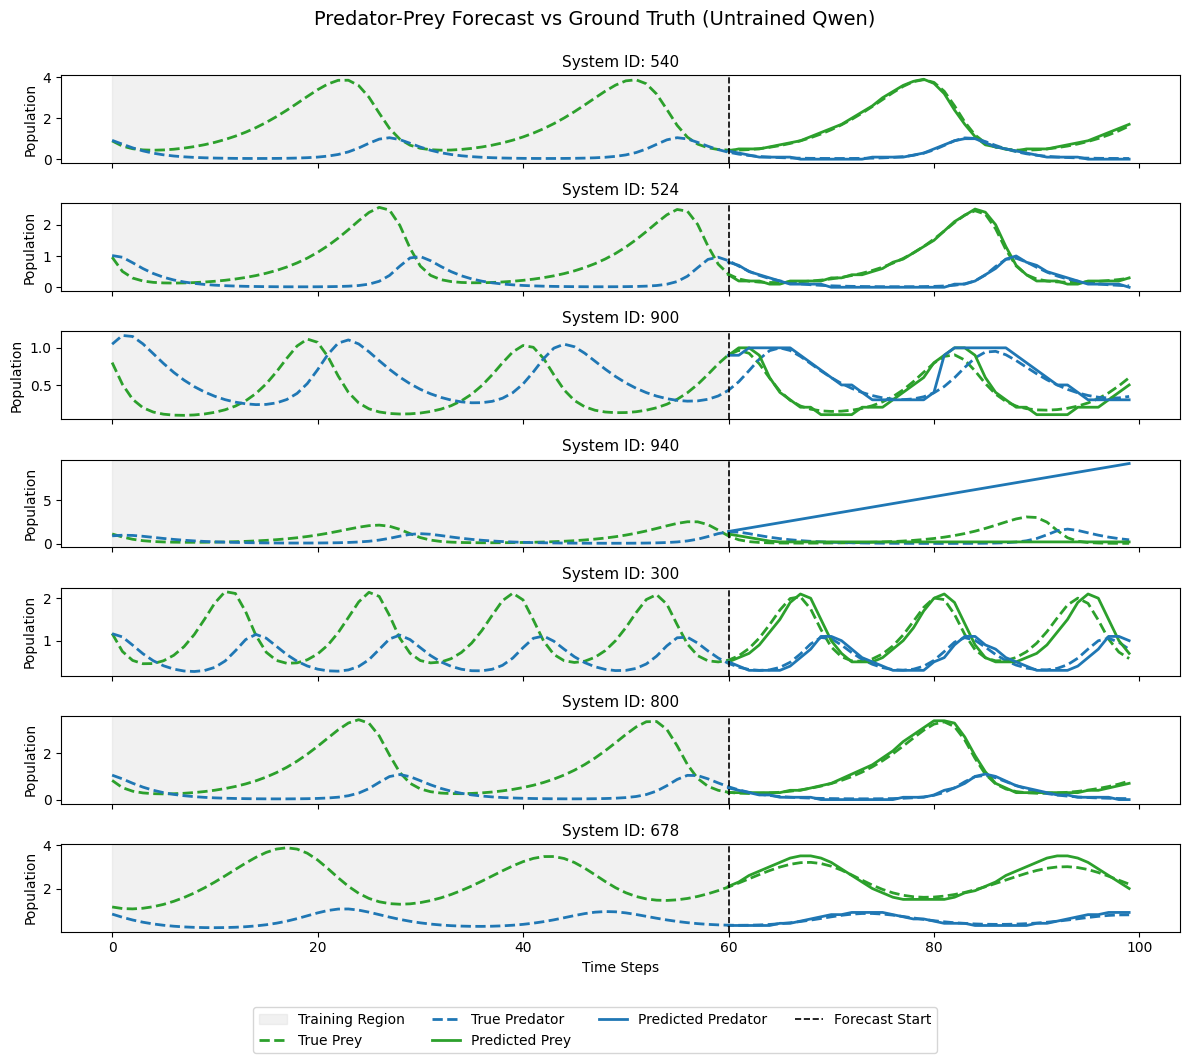

In [28]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, tokenizer = load_qwen()
model.to(device)
model.eval()

# --- Load data
preprocessor = LLMTIMEPreprocessor()
trajectories = h5py.File("lotka_volterra_data.h5", "r")["trajectories"][:]

true_predator_color = '#1f77b4'
pred_predator_color = '#1f77b4'
true_prey_color = '#2ca02c'
pred_prey_color = '#2ca02c'

# SYSTEM_IDS = [200,300,800,900,250,550,450,825,475]
SYSTEM_IDS = [540,524,900,940,300,800,678]
print(len(SYSTEM_IDS))
TIME_STEPS = 100
SPLIT_POINT = 60
SCALE_FACTOR = 10
predictions_list = []


# --- 4x1 Grid Plot (Consistent styling)
fig, axs = plt.subplots(7, 1, figsize=(12, 10), sharex=True)
axs = axs.flatten()

for idx, system_id in enumerate(SYSTEM_IDS):
    sequence = trajectories[system_id, :, :]
    input_sequence = sequence[:SPLIT_POINT]
    true_output_sequence = sequence[SPLIT_POINT:]

    preprocessed_input = preprocessor.preprocess_sequence(input_sequence)
    tokenized_input = preprocessor.tokenize_sequence(preprocessed_input)
    input_tensor = torch.tensor([tokenized_input]).to(model.device)

    prediction = run_prediction(model, tokenizer, input_tensor, 1)


    # R squared

    true_prey = true_output_sequence[:, 0]
    true_predator = true_output_sequence[:, 1]
    pred_prey = prediction[:, 0]
    pred_predator = prediction[:, 1]

    r2_prey = r2_score(true_prey, pred_prey)
    r2_predator = r2_score(true_predator, pred_predator)

    print(f"{system_id}, R-squared for Prey: {r2_prey}")
    print(f"{system_id}, R-squared for Predator: {r2_predator}")

    print(device)

    predictions_list.append({
    "system_id": system_id,
    "predicted_prey": prediction[:, 0].tolist(),
    "predicted_predator": prediction[:, 1].tolist()
    })

    ax = axs[idx]
    # Shade training region
    ax.axvspan(0, SPLIT_POINT, color='lightgrey', alpha=0.3, label="Training Region" if idx == 0 else None)

    # True values
    ax.plot(range(TIME_STEPS), sequence[:, 0], label="True Prey", linestyle="--", color="#2ca02c", linewidth=2)
    ax.plot(range(TIME_STEPS), sequence[:, 1], label="True Predator", linestyle="--", color="#1f77b4", linewidth=2)

    # Predictions
    forecast_range = range(SPLIT_POINT, SPLIT_POINT + len(prediction))
    ax.plot(forecast_range, prediction[:, 0], label="Predicted Prey", linestyle="-", color="#2ca02c", linewidth=2)
    ax.plot(forecast_range, prediction[:, 1], label="Predicted Predator", linestyle="-", color="#1f77b4", linewidth=2)

    # Forecast start
    ax.axvline(x=SPLIT_POINT, color='black', linestyle='--', lw=1.2, label="Forecast Start" if idx == 0 else None)

    ax.set_title(f"System ID: {system_id}", fontsize=11)
    ax.set_ylabel("Population")

axs[-1].set_xlabel("Time Steps")

# Shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02), fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.suptitle("Predator-Prey Forecast vs Ground Truth (Untrained Qwen)", fontsize=14, y=1.03)

plt.savefig("att1.png", dpi=300, bbox_inches='tight')
plt.show()

df = pd.DataFrame(predictions_list)
df.to_csv("449460_untrained.csv", index=False)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset


# Force everything to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and move to CPU
model, tokenizer = load_qwen()
model.to(device)

# Apply LoRA to Query & Value Projection Layers
lora_rank = 8
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank)

# Load dataset
train_texts, val_texts = load_and_preprocess("lotka_volterra_data.h5", num_systems=100, time_steps=10, fraction=0.8)

# Set optimized training settings
max_ctx_length = 256  #  Updated to match skeleton
batch_size = 2  #  Use correct batch size
learning_rate = 0.0001

# Convert tokenized text into tensors
train_input_ids = process_sequences(train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2)
val_input_ids = process_sequences(val_texts, tokenizer, max_ctx_length)

#  Prepare DataLoaders
train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#  Optimizer (only trainable LoRA parameters)
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000)

#  Use Accelerator for efficient training
accelerator = Accelerator()
model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

train_losses = []
val_losses = []
true_series = []
predicted_series = []
eval_interval = 100  # Evaluate validation loss every 100 steps

for param in model.parameters():
    param.data = param.data.to("cpu")
    if param.grad is not None:
        param.grad.data = param.grad.data.to("cpu")

for buffer in model.buffers():
    buffer.data = buffer.data.to("cpu")

#  Train LoRA Model
model.train()
steps = 0
while steps < 500:
    progress_bar = tqdm(train_loader, desc=f"Steps {steps}")
    for (batch,) in progress_bar:
        optimizer.zero_grad()
        batch = batch.to(device, dtype=torch.long)  # Ensure input is on CPU

        outputs = model(batch, labels=batch)
        loss = outputs.loss
        accelerator.backward(loss)
        optimizer.step()
        steps += 1

        train_losses.append(loss.item())

        progress_bar.set_postfix(loss=loss.item())

        if steps % eval_interval == 0:
            model.eval()
            val_loss_total = 0
            with torch.no_grad():
                for (val_batch,) in val_loader:
                    val_batch = val_batch.to(device, dtype=torch.long)
                    val_outputs = model(val_batch, labels=val_batch)
                    val_loss_total += val_outputs.loss.item()
            avg_val_loss = val_loss_total / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f"Step {steps}: Validation Loss = {avg_val_loss}")
            model.train()  # Switch back to training model

        if steps >= 500:
            break

#  Final Model Save
torch.save(model.state_dict(), "lora_qwen2.5_new_1.pth")

#  Save Train & Validation Losses to CSV
pd.DataFrame({"train_loss": train_losses}).to_csv(f"train_loss_new1.csv", index=False)
pd.DataFrame({"val_loss": val_losses}).to_csv(f"val_loss_new1.csv", index=False)